## Depth Testing Gratings

You gotta feed this code nice numbers, and by that I mean the same ones for both dimensions and hopefully
in mulitples of two like for real space values in microns and periods, and the pixels counts, and 
everything will just work better if you type in values that are multiples of two 
so do that
 

In [2]:
from ktc_tools import grating_generation as ggen
from ktc_tools import streams as st
from ktc_tools import fourier_diffraction as fd

import numpy as np
from matplotlib import pyplot as plt
import matplotlib

## Parameters for the test pattern

In [24]:
#horizontal field width
hfw =  40 #in units of microns 
#5 microseconds is the smallest dwell time that the FIB2 software will allow
dwellTime = 50 #in units of .1 microseconds due to streamfile convention
#how far apart will our mill points be
millDens = 50 #points per micron

#number of slices we want to split the grating into
############################################################
layerNum = 17 #for some reason this is 1 + the number you want


In [25]:
#testing different pass numbers
passTestNum = 4
minPassNum = 400

#creating an array for the number of passes per slice
passPerSliceMin = round(minPassNum / layerNum)
passPerSliceStep = 8
passPerSliceMax = passPerSliceMin + passPerSliceStep * passTestNum
passPerSliceArr = np.arange(passPerSliceMin,passPerSliceMax,passPerSliceStep)
print("pass per slice values we will try")
print(passPerSliceArr)
print("min passes: ", minPassNum, " max passes: ",passPerSliceMax*(layerNum - 1))

testSpacing = 3 #do the tests 1 microns apart

#number of rows we want in our grid since the only parameter
#we are varying is the pass number
rowNum = 2 #this must be a divisor of passTestNum
colNum = int(passTestNum / rowNum)

pass per slice values we will try
[24 32 40 48]
min passes:  400  max passes:  896


### Define Blazed Grating
This is the shape that will be inserted into each test rectangle

max num meaningful slices:  15.0
blazed array length:  14.990625


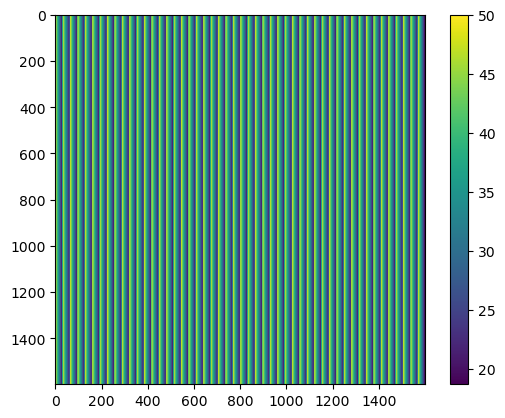

In [30]:
#first step is to import the grating array from whatever workflow you used to generate it
testPeriod = .3 #a period of 150 nm

#calculate the max number of meaningfully different layers
#based on the stream pixel density and the period of the pattern
print("max num meaningful slices: ",testPeriod * millDens)

nTestX= 1600
nTestY= 1600
periodPix = 32

thickness = 50
depth = 32

xaxis, gratingArray = ggen.oneDimensionBlazed(nTestX,periodPix,thickness = thickness\
                                            ,depth = depth,period = testPeriod,fracPos = .99)

plt.imshow(gratingArray)
plt.colorbar()

#originally I thought these might be different but I think
#it is best to leave them the same, I think there are no bugs if they're different
#but you can never be too careful
testSizeHorz = xaxis[0,-1]
testSizeVert = testSizeHorz

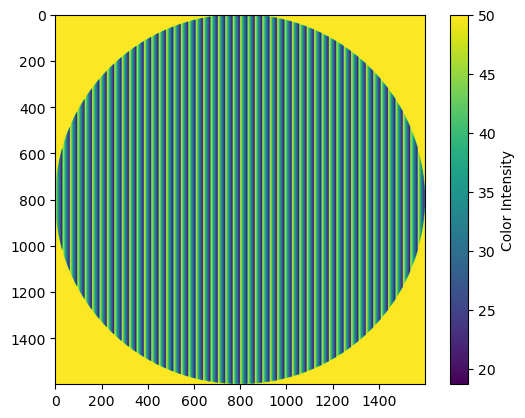

In [31]:
#use the function I already wrote for diffraction
circGratingArr = fd.circleAperture(gratingArray,rfrac = .5)
#this is what we really wanted
circGratingArr[circGratingArr == 0] = thickness

plt.imshow(circGratingArr)
plt.colorbar(label='Color Intensity')

### Create Grid of Gratings

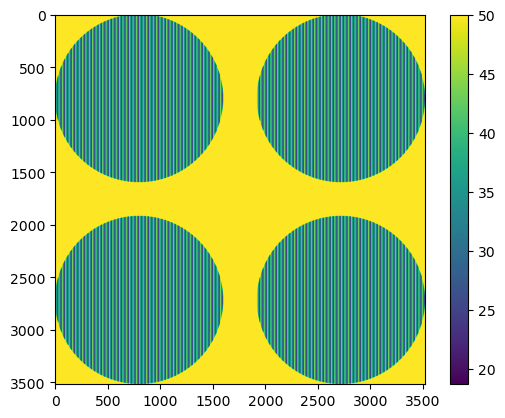

In [32]:
gratingGrid = ggen.genGratingGrid(circGratingArr,rowNum,colNum,\
                            testSpacing,testSizeHorz,testSizeVert,spacerValue = thickness)
plt.imshow(gratingGrid)
plt.colorbar()

### Do Geometric Calculations for Streamfiles and Grid

In [33]:
totalTestWidth = testSizeHorz * colNum + testSpacing * (colNum - 1)
totalTestVert = testSizeVert * rowNum + testSpacing * (rowNum - 1)

spacingWidthRatio = testSpacing / totalTestWidth
spacingHeightRatio = testSpacing /totalTestVert

print("the test will stretch")
print(totalTestWidth," microns horizontally")  
print(totalTestVert," microns vertically\n")

nTestArrY = gratingGrid.shape[0]
nTestArrX = gratingGrid.shape[1]

millArrDensX, lengthStreamX = st.streamConversions(hfw,millDens,totalTestWidth,nTestArrX)
millArrDensY, lengthStreamY = st.streamConversions(hfw,millDens,totalTestVert,nTestArrY)

the test will stretch
32.98125  microns horizontally
32.98125  microns vertically

each returned array pixel represents
15.35127272727273 streamfile pixels

mill point spacing values in streamfile pixels
32.768 

the mill points will be seperated by 
2  pixels in the returned arrays

each returned array pixel represents
15.35127272727273 streamfile pixels

mill point spacing values in streamfile pixels
32.768 

the mill points will be seperated by 
2  pixels in the returned arrays



### Slice Grid

slice the grid in the z direction, save each slice as an item in a list

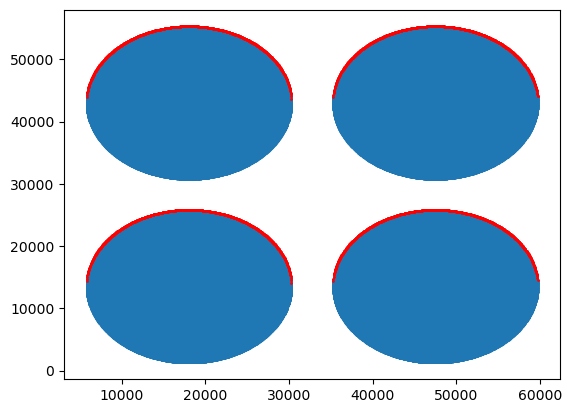

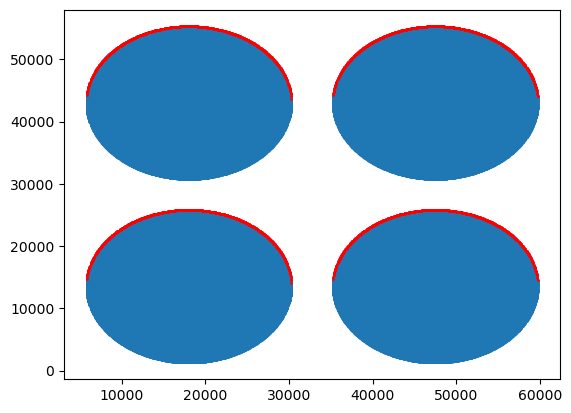

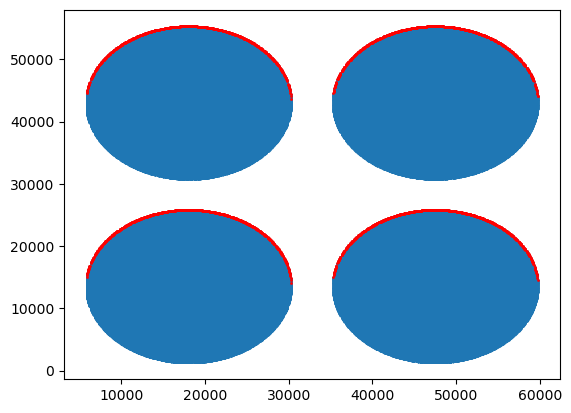

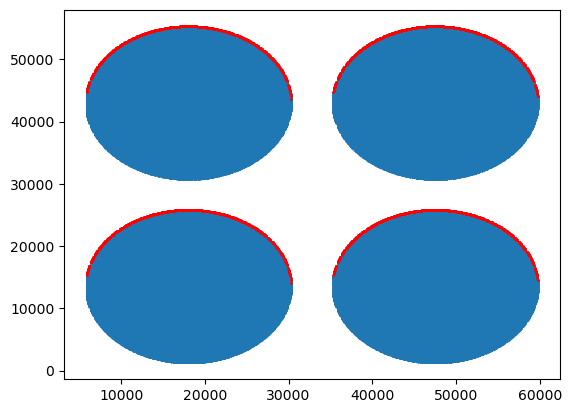

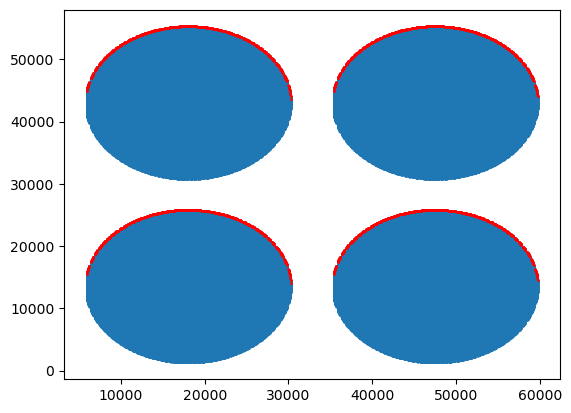

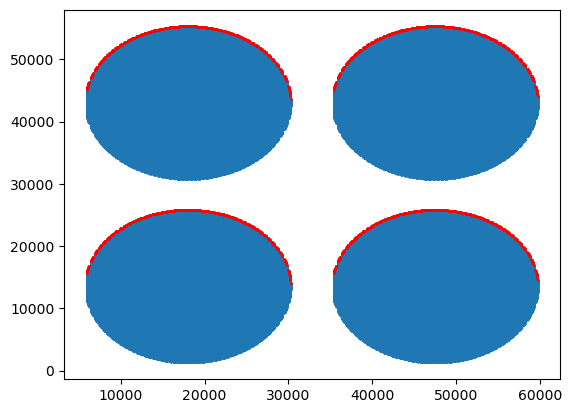

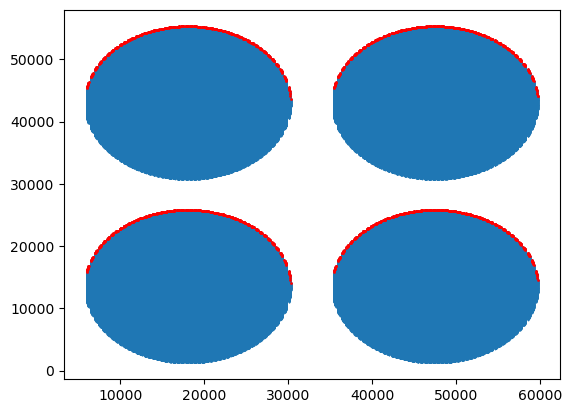

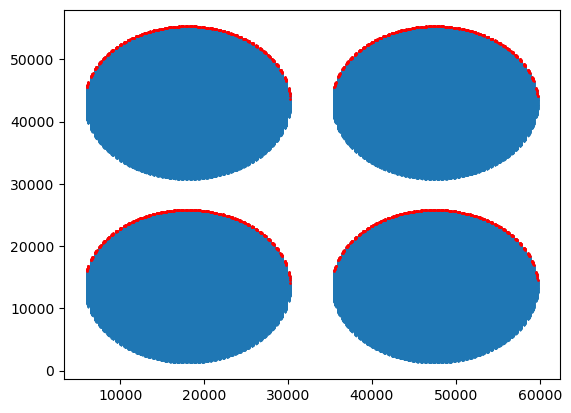

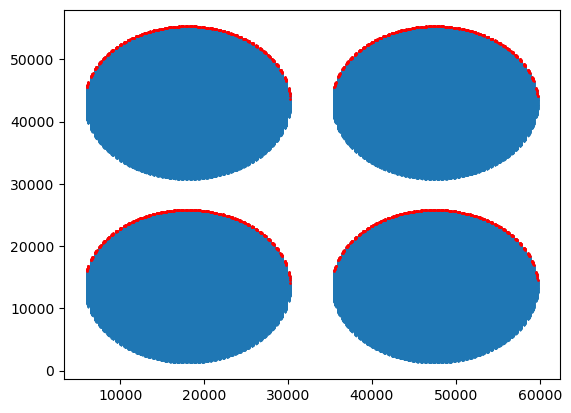

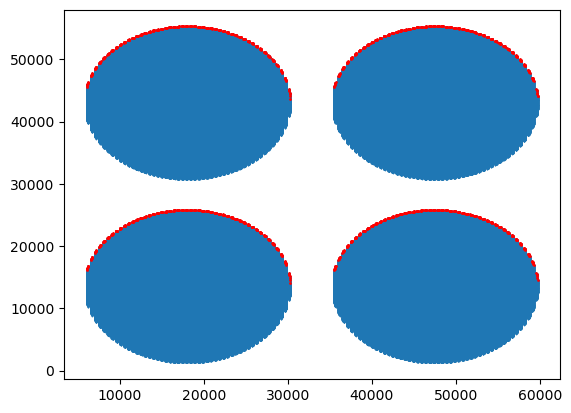

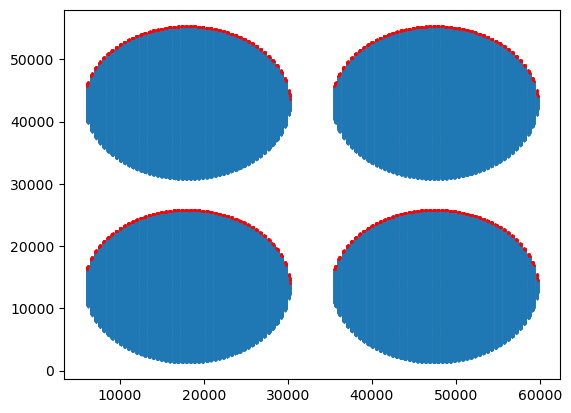

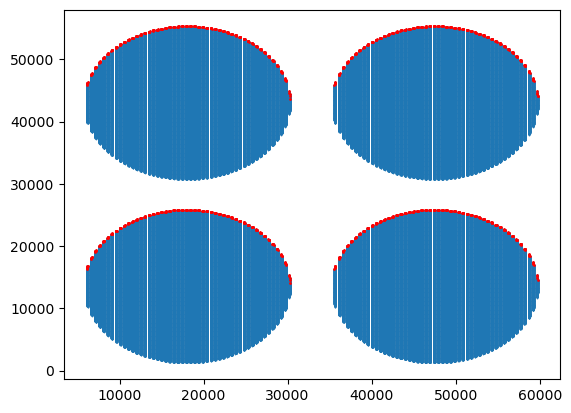

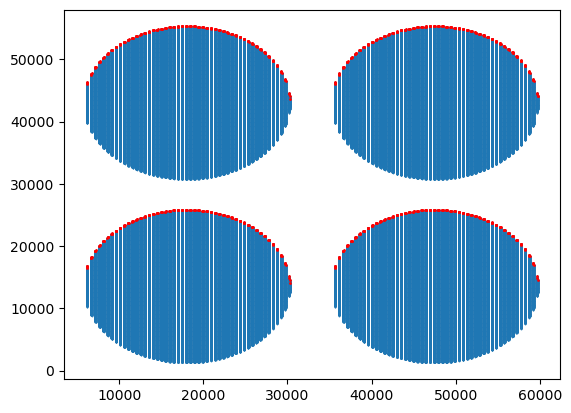

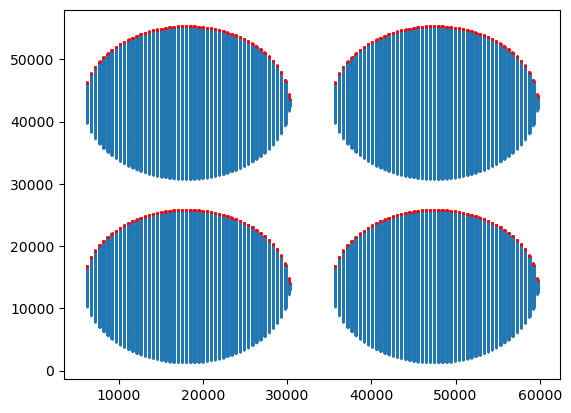

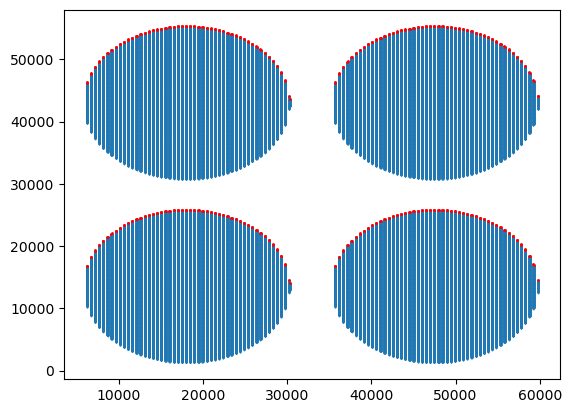

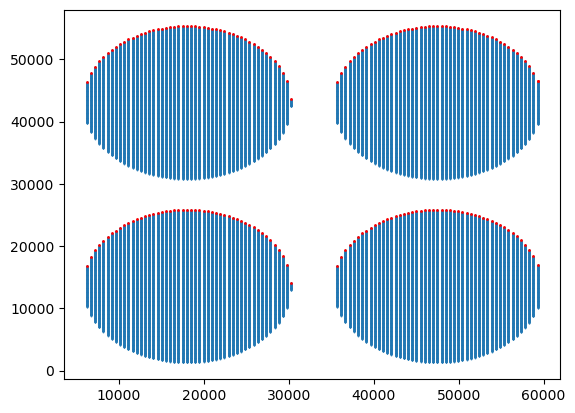

In [34]:
gratingSliceList = st.sliceStreamList(layerNum,thickness,depth,\
                                    gratingGrid,millArrDensX,lengthStreamX,lengthStreamY)

### Split Slices into Grid
use the stream grid split function to split the stream array that represents each slice in the list above into a grid based on its spatial indexing

16


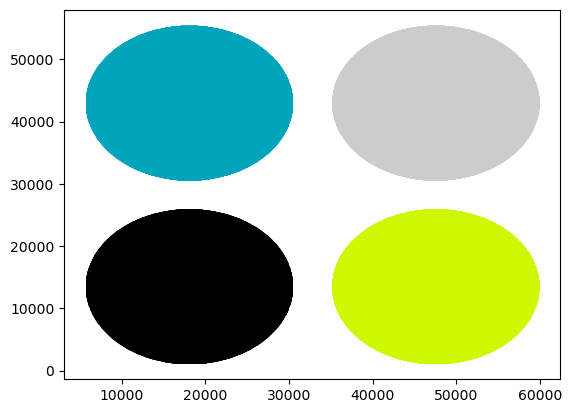

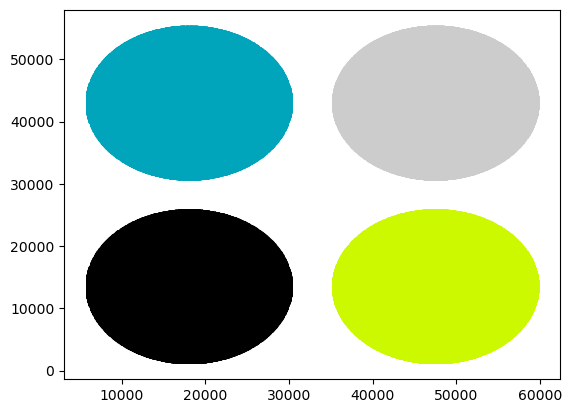

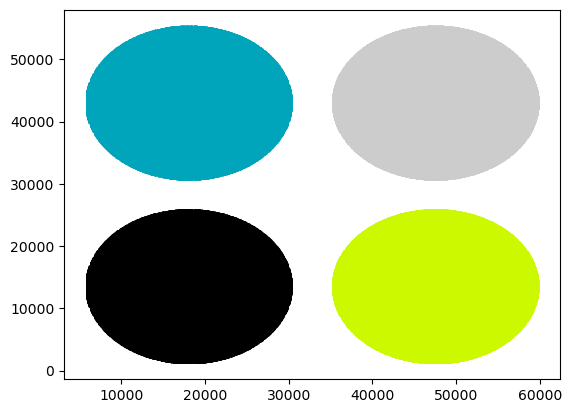

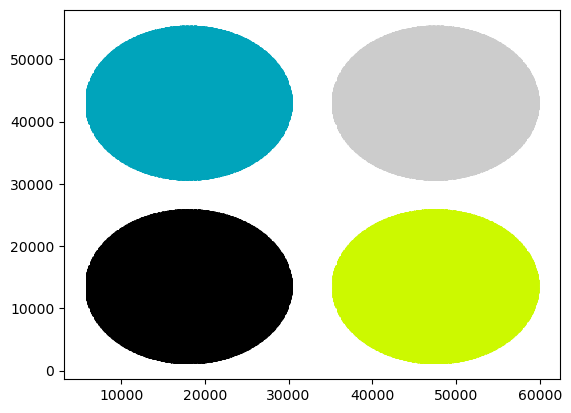

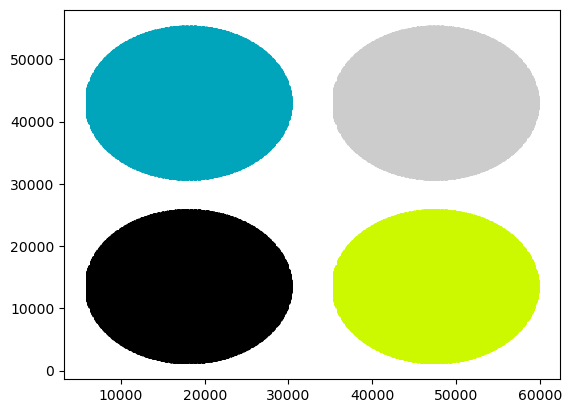

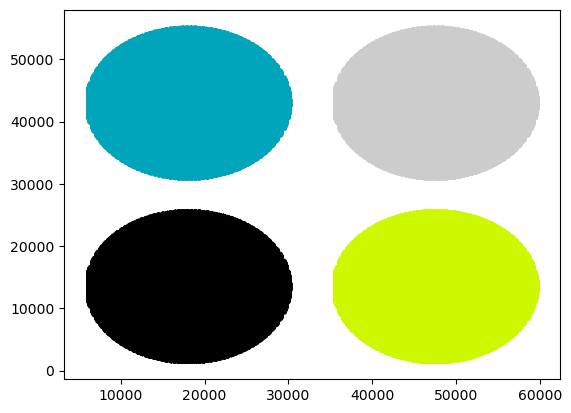

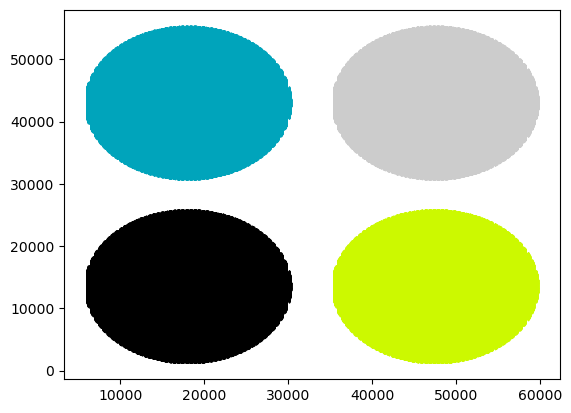

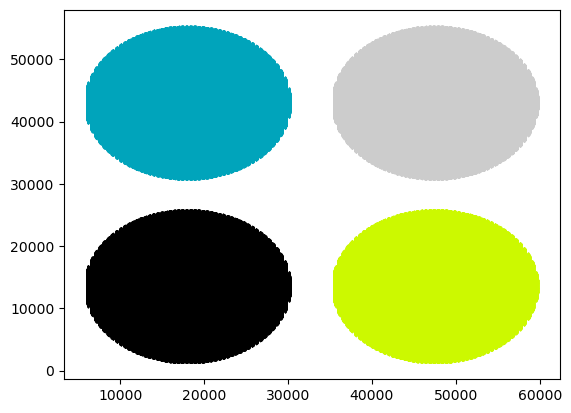

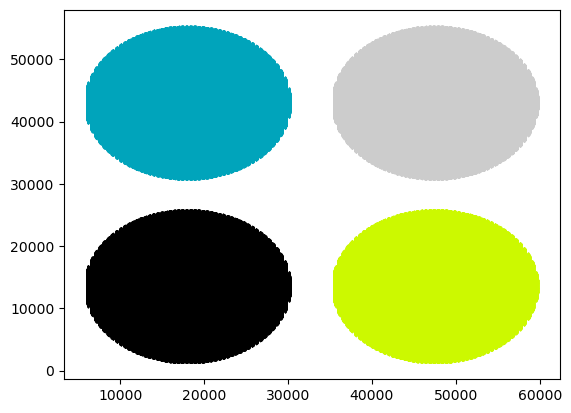

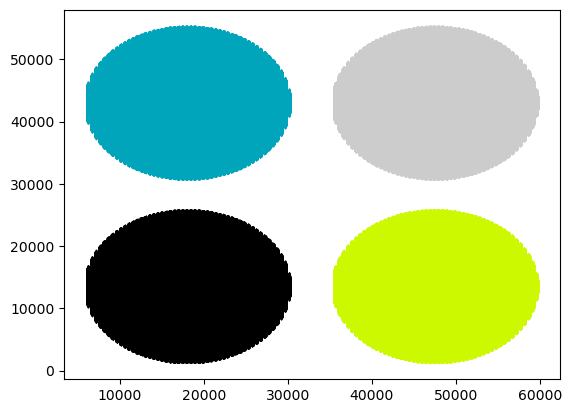

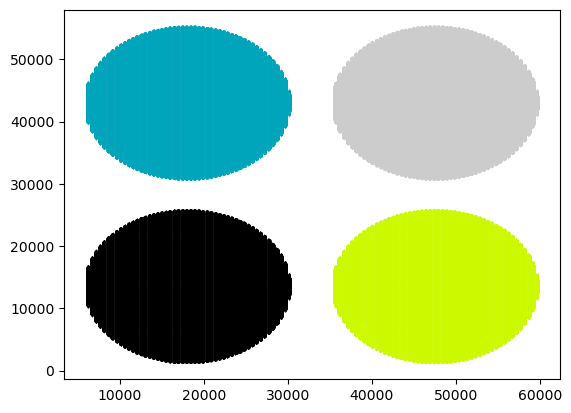

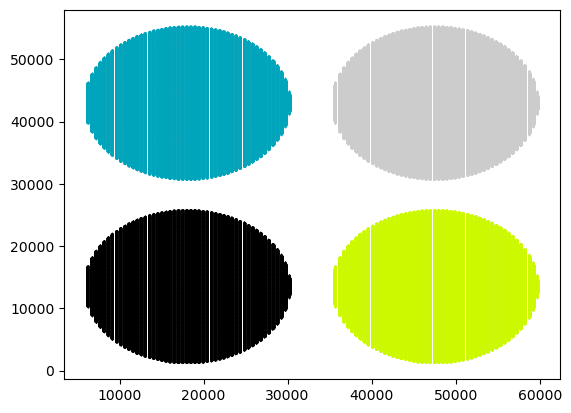

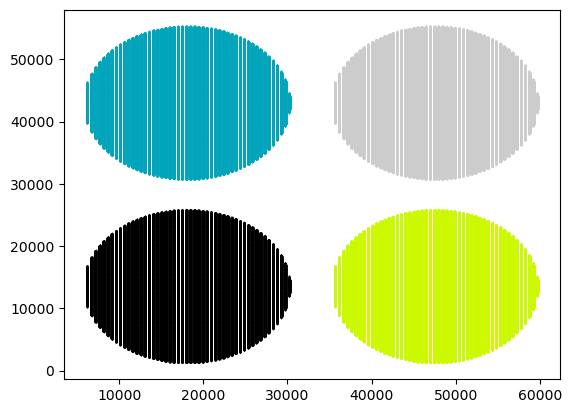

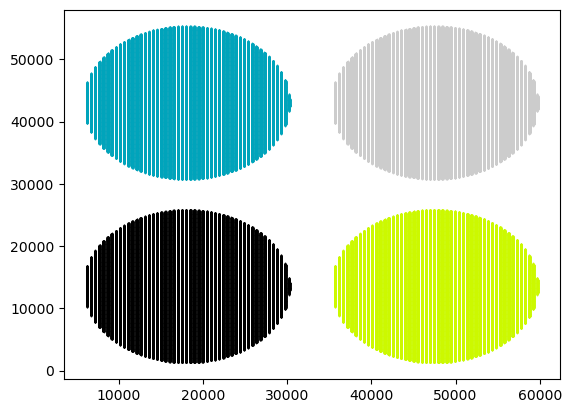

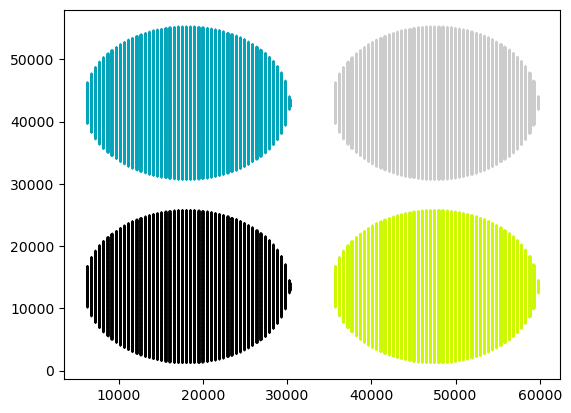

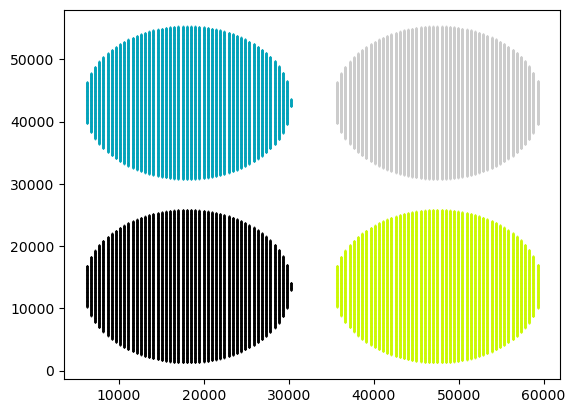

In [35]:
sliceGridList = []
#we now have a list of lists where the first index is the slice, and the second index is 
#the location in the larger grid 
count = 0
for item in gratingSliceList:
    plt.figure()
    gridListCurr = st.streamGridSplit(item,spacingWidthRatio,spacingHeightRatio\
                ,lengthStreamX,lengthStreamY,colNum,rowNum)
    sliceGridList.append(gridListCurr)
    # plt.show()
    count+=1

print(count)


### Actually Make the Streamfiles

In [37]:
#filepath where we will save everything
saveFolder = "streamFiles/BlazedTest_40umHFW_40pA_300nm_16slices/"
baseName = saveFolder + "blazedGridTest"

#loop through our slices
sliceNum = 0
i = 0
for gridList in sliceGridList:
    sliceNum += 1

    #loop through our grid locations
    gridNum = 0
    for gridArr in gridList:

        #get the number of passes from the pass array
        currPasses = round(passPerSliceArr[gridNum])

        gridNum +=1
        i += 1

        fileName = baseName + '{:03d}'.format(i) + "_" + str(currPasses) + "passes"\
                 + ".str"
        # print(fileName)
        #actually generate the streamfile
        st.generateStreamFile(gridArr,currPasses,dwellTime,fileName)
